In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.io as pio
import plotly.express as px

from ast import literal_eval

try:
    from cfuzzyset import cFuzzySet as FuzzySet
except ImportError:
    from fuzzyset import FuzzySet


pd.options.plotting.backend = "plotly"
pio.renderers.default = 'browser'
pio.templates.default = 'plotly_dark'

In [2]:
pt_df = pd.read_csv("./data/pt_ratings.csv")
salaries_df = pd.read_csv("./data/salaries.csv")
rmp_df = pd.read_csv("./data/rmp_ratings.csv")


In [3]:
# Drop professors w/o any ratings / reviews
pt_df = pt_df.dropna(subset=["average_rating", "reviews"])
# pt_df = pt_df.drop(columns=["slug"])

# Join names to help name search in salaries
salaries_df["name"] = salaries_df["employee"].apply(
    lambda x: " ".join(x.split(", ")[::-1])
)
salaries_df["department"] = salaries_df["department"].str.replace("\n", " ").str.strip()
salaries_df["salary"] = salaries_df["salary"].replace('[\$,]', '', regex=True).astype(float)
salaries_df["school"] = salaries_df["department"].str.split("-").str[0]
salaries_df.loc[~salaries_df["department"].str.contains("-"), "school"] = np.nan

# Join names to help name search in rmp
def combineNames(row):
    if pd.isnull(row["tMiddlename"]):
        return row["tFname"] + " " + row["tLname"]
    return row["tFname"] + " " + row["tMiddlename"] + " " + row["tLname"]


rmp_df["name"] = rmp_df.apply(combineNames, axis=1)


In [4]:
for name in pt_df[pt_df.duplicated(subset=["name"])]["name"].unique():
    rows = pt_df[pt_df["name"] == name]

    assert len(rows["type"].unique()) == 1
    assert len(rows["name"].unique()) == 1

    new_row = {
        "courses": np.concatenate(rows["courses"].apply(literal_eval).values).reshape(-1),
        "reviews": np.concatenate(rows["reviews"].apply(literal_eval).values).reshape(-1),
        "slug": rows.iloc[0]["slug"],
        "type": rows.iloc[0]["type"],
        "name": rows.iloc[0]["name"],
        "average_rating": np.average(rows["average_rating"], weights=rows["reviews"].apply(literal_eval).apply(len)),
    }
    
    pt_df = pt_df.drop(rows.index)
    pt_df = pt_df.append(new_row, ignore_index=True)

/tmp/ipykernel_19627/1614537991.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [5]:
pt_df.head()

,courses,average_rating,type,reviews,name,slug
0,"['ENME674', 'ENMA300', 'ENME684', 'ENME489Z', ...",5.0000,professor,"[{'professor': 'Abhijit Dasgupta', 'course': '...",Abhijit Dasgupta,dasgupta_abhijit
1,"['ARTH389L', 'ARTH255', 'ARTH768', 'ARTH668A',...",2.8333,professor,"[{'professor': 'Abigail McEwen', 'course': Non...",Abigail McEwen,mcewen
2,"['PHYS405', 'PHYS275', 'PHYS758E', 'PHYS273', ...",4.0000,professor,"[{'professor': 'Abolhassan Jawahery', 'course'...",Abolhassan Jawahery,jawahery
3,"['STAT701', 'STAT700', 'STAT750', 'STAT650', '...",2.7000,professor,"[{'professor': 'Abram Kagan', 'course': 'STAT4...",Abram Kagan,kagan
4,"['ENGL101', 'ENGL243', 'ENGL101S', 'PHSC497', ...",5.0000,professor,"[{'professor': 'Adam Binkley', 'course': 'ENGL...",Adam Binkley,binkley


In [6]:
rmp_df.head()

,tDept,tSid,institution_name,tFname,tMiddlename,tLname,tid,tNumRatings,rating_class,contentType,categoryType,overall_rating,name
0,Computer Science,1270,University of Maryland,Daniel,NaN,Abadi,2361198,1,poor,TEACHER,PROFESSOR,1.0,Daniel Abadi
1,Foreign Languages,1270,University of Maryland,Ali,NaN,Abasi,972417,7,poor,TEACHER,PROFESSOR,2.4,Ali Abasi
2,Physics,1270,University of Maryland,Kevork,NaN,Abazajian,1556681,3,good,TEACHER,PROFESSOR,5.0,Kevork Abazajian
3,Languages,1270,University of Maryland,Ali,NaN,Abbasi,1400739,1,good,TEACHER,PROFESSOR,5.0,Ali Abbasi
4,Economics,1270,University of Maryland,Hossein,NaN,Abbasi,2205764,63,average,TEACHER,PROFESSOR,2.7,Hossein Abbasi


In [7]:
salaries_df.head()

,year,employee,department,division,title,salary,name,school
0,2013,"Abed, Eyad H",ENGR-Electrical & Computer Engineering,A. James Clark School of Engineering,Prof,216648.00,Eyad H Abed,ENGR
1,2013,"Abshire, Pamela A.",ENGR-Electrical & Computer Engineering,A. James Clark School of Engineering,Assoc Prof,82872.96,Pamela A. Abshire,ENGR
2,2013,"Abshire, Pamela A.",ENGR-Institute for Systems Research,A. James Clark School of Engineering,Assoc Prof,55149.36,Pamela A. Abshire,ENGR
3,2013,"Abts, Leigh R",ENGR-Fischell Department of Bioengineering,A. James Clark School of Engineering,Res Assoc Prof,126334.14,Leigh R Abts,ENGR
4,2013,"Adams, Douglas J",ENGR-Continuing & Distance Learning in Engr,A. James Clark School of Engineering,Engineer,64260.00,Douglas J Adams,ENGR


In [19]:
pd.set_option('display.max_rows', 500)
salaries_df["school"].value_counts()

CMNS      15826
VPSA      12777
VPAF       9812
ARHU       9375
ENGR       9237
AGNR       7923
BSOS       7283
BMGT       4342
PRES       3364
SVPAAP     3245
EDUC       3035
SPHL       2419
VPR        2241
VPUR       2053
DIT        1864
LIBR       1848
UGST       1468
VPAA       1261
VPA        1155
ARCH       1070
INFO       1021
IT          899
JOUR        868
USG         753
PLCY        681
EXST        610
PUAF        369
GRAD        202
VPF          89
SGC          83
Name: school, dtype: int64

In [9]:
pt_df["type"].value_counts()

professor    2933
ta            133
Name: type, dtype: int64

In [10]:
assert len(pt_df) == len(pt_df.drop_duplicates(subset=["name"]))

In [11]:
def get_fl(s):
    sl = s.split()
    return f"{sl[0]} {sl[-1]}"


salary_fuzz = FuzzySet(salaries_df["name"].unique())
salary_fl_fuzz = FuzzySet(salaries_df["name"].apply(get_fl).unique())

matches_salary_to_pt = {}

l = len(pt_df["name"].unique())
for i, pt_name in enumerate(pt_df["name"].unique()):
    matches = salary_fuzz.get(pt_name)
    match_conf, match_name = matches[0]
    print(f"[{i + 1}/{l}] {pt_name} -> {matches}")

    if match_conf <= 0.75:
        matches = salary_fl_fuzz.get(pt_name)
        match_conf, match_name = matches[0]
        print("RETRY")
        print(f"[{i + 1}/{l}] {pt_name} -> {matches}")

    if match_conf >= 0.75:
        matches_salary_to_pt[match_name] = pt_name

len(matches_salary_to_pt)


[1/3066] Abhijit Dasgupta -> [(1, 'Abhijit Dasgupta')]
[2/3066] Abigail McEwen -> [(1, 'Abigail McEwen')]
[3/3066] Abolhassan Jawahery -> [(1, 'Abolhassan Jawahery')]
[4/3066] Abram Kagan -> [(1, 'Abram Kagan')]
[5/3066] Adam Binkley -> [(0.7058823529411764, 'Adam Ross Binkley')]
RETRY
[5/3066] Adam Binkley -> [(1, 'Adam Binkley')]
[6/3066] Adam Hsieh -> [(0.7692307692307692, 'Adam H. Hsieh')]
[7/3066] Adam Porter -> [(0.7857142857142857, 'Adam A. Porter')]
[8/3066] Adi Mahalel -> [(1, 'Adi Mahalel')]
[9/3066] Adil Hassam -> [(1, 'Adil Hassam')]
[10/3066] Adriane Fang -> [(1, 'Adriane Fang')]
[11/3066] Adrianos Papamarcou -> [(1, 'Adrianos Papamarcou')]
[12/3066] Agisilaos Iliadis -> [(1, 'Agisilaos Iliadis')]
[13/3066] Ahmad Karimi-Hakkak -> [(1, 'Ahmad Karimi-Hakkak')]
[14/3066] Ahmet Aydilek -> [(0.8125, 'Ahmet H. Aydilek')]
[15/3066] Ahmet Karamustafa -> [(0.7647058823529411, 'Ali Karamustafa')]
[16/3066] Alan Drew -> [(0.8181818181818181, 'Alan C Drew')]
[17/3066] Alan Kaufman -> 

/tmp/ipykernel_19627/3370154677.py:13: DeprecationWarning:

This function will be remove in v3.0.0. Use rapidfuzz.distance.Levenshtein.normalized_similarity instead.

/tmp/ipykernel_19627/3370154677.py:18: DeprecationWarning:

This function will be remove in v3.0.0. Use rapidfuzz.distance.Levenshtein.normalized_similarity instead.



[158/3066] Caroline Wilkins -> [(0.8421052631578947, 'Caroline A. Wilkins')]
[159/3066] Carolyn Fink -> [(0.7142857142857143, 'Carolyn Lisane')]
RETRY
[159/3066] Carolyn Fink -> [(1, 'Carolyn Fink')]
[160/3066] Carter Hall -> [(1, 'Carter Hall')]
[161/3066] Casey Cremins -> [(1, 'Casey Cremins')]
[162/3066] Cassandra Clayton -> [(0.85, 'Cassandra L. Clayton')]
[163/3066] Cassondra Pope -> [(0.875, 'Cassondra N Pope')]
[164/3066] Catherine Bayly -> [(0.7647058823529411, 'Catherine Maybury')]
[165/3066] Catherine Carr -> [(0.8125, 'Katherine Carter'), (0.8125, 'Catherine Parker')]
[166/3066] Catherine Schuler -> [(0.85, 'Catherine A. Schuler')]
[167/3066] Ceil Goldberg -> [(1, 'Ceil Goldberg')]
[168/3066] Chandrasekhar Thamire -> [(1, 'Chandrasekhar Thamire')]
[169/3066] Chantel Rodriguez -> [(1, 'Chantel Rodriguez')]
[170/3066] Charalampos Papamanthou -> [(1, 'Charalampos Papamanthou')]
[171/3066] Charles Alford -> [(0.6842105263157895, 'Charles F. Wellford')]
RETRY
[171/3066] Charles A

2561

In [12]:
assert len(set(matches_salary_to_pt.keys())) == len(set(matches_salary_to_pt.values()))

print(len(matches_salary_to_pt))
print(len(salaries_df["name"].unique()))

2561
26529


In [13]:
salaries_df.dtypes

year            int64
employee       object
department     object
division       object
title          object
salary        float64
name           object
school         object
dtype: object

In [14]:
tmp = []

for (salary_name, year), salary_rows in salaries_df.groupby(["name", "year"]):
    if year != 2022 or salary_name not in matches_salary_to_pt:
        continue

    assert len(salary_rows["name"].unique()) == 1

    # TODO: count only reviews up to year
    # display(rows)

    pt_name = matches_salary_to_pt[salary_name]
    pt_rows = pt_df[pt_df["name"] == pt_name]

    assert len(pt_rows) == 1

    pt_row = pt_rows.iloc[0]

    reviews = literal_eval(pt_row["reviews"])

    tmp.append(
        {
            "name": salary_name,
            "average_rating": pt_row["average_rating"],
            "year": year,
            "school": salary_rows.iloc[0]["school"],
            "salary": salary_rows["salary"].sum(),
            "num_reviews": len(reviews),
            "department": salary_rows.iloc[0]["department"],
        }
    )

tmp = pd.DataFrame(tmp)
tmp


,name,average_rating,year,school,salary,num_reviews,department
0,A W. Kruglanski,2.000,2022,BSOS,328606.76,1,BSOS-Psychology
1,Aaron Finkle,3.000,2022,BSOS,77699.70,5,BSOS-Economics
2,Aaron Hood,5.000,2022,VPSA,58556.29,3,VPSA-Resident Life
3,Abhijit Dasgupta,5.000,2022,ENGR,227086.06,2,ENGR-Mechanical Engineering
4,Abhinav Bhatele,4.000,2022,CMNS,180428.27,3,CMNS-Computer Science
...,...,...,...,...,...,...,...
1309,Zhengguo Xiao,4.000,2022,AGNR,132691.82,1,AGNR-Animal & Avian Sciences
1310,Zhi Xiang Lin,5.000,2022,UGST,10100.00,2,UGST-Honors College
1311,Zhongchi Liu,4.625,2022,CMNS,128494.72,8,CMNS-Cell Biology & Molecular Genetics
1312,Zohreh Davoudi,2.000,2022,CMNS,164761.66,4,CMNS-Physics


In [15]:
tmp[tmp["num_reviews"] > 10].sort_values(by=["average_rating", "salary"], ascending=[True, False])

,name,average_rating,year,school,salary,num_reviews,department
79,Andris Skuja,1.2667,2022,CMNS,139087.07,15,CMNS-Physics
448,Heather L Tienson-Tseng,1.4286,2022,CMNS,57570.00,28,CMNS-Chemistry & Biochemistry
873,Michel Cukier,1.4545,2022,ENGR,202907.30,11,ENGR-Mechanical Engineering
442,Hanan Samet,1.5000,2022,CMNS,343420.83,12,CMNS-Computer Science
721,Leah G Dodson,1.6667,2022,CMNS,97906.03,57,CMNS-Chemistry & Biochemistry
412,Gerald Borgia,1.6875,2022,CMNS,118546.17,16,CMNS-Biology
65,Amy S. Mullin,1.7273,2022,CMNS,179499.10,11,CMNS-Chemistry & Biochemistry
1101,Sangeetha Madhavan,1.7500,2022,BSOS,207050.00,12,BSOS-African American Studies
841,Melissa Carry,1.8000,2022,UGST,47290.87,20,UGST-Academic Achievement Programs
798,Mark D Fuge,1.8182,2022,ENGR,182666.51,11,ENGR-Mechanical Engineering


In [16]:
tmp[tmp["num_reviews"] > 10]

,name,average_rating,year,school,salary,num_reviews,department
7,Adam A. Porter,2.5000,2022,CMNS,165991.71,12,CMNS-Computer Science
12,Adrianos Papamarcou,4.1429,2022,ENGR,123336.92,28,ENGR-Electrical & Computer Engineering
13,Agisilaos Iliadis,2.3750,2022,ENGR,163382.57,16,ENGR-Electrical & Computer Engineering
17,Alan C Peel,3.5000,2022,CMNS,81919.04,12,CMNS-Astronomy
31,Alexandra E. Bely,4.0000,2022,CMNS,131174.31,14,CMNS-Biology
37,Alice C. Mignerey,2.2500,2022,CMNS,129185.20,44,CMNS-Chemistry & Biochemistry
44,Alka Gandhi,3.7632,2022,BSOS,92901.82,38,BSOS-Economics
45,Allan Drazen,2.0000,2022,BSOS,260731.99,11,BSOS-Economics
53,Amanda Chicoli,3.6250,2022,BSOS,76953.34,16,BSOS-Psychology
54,Amanda J. Schech,3.7576,2022,CMNS,65312.78,33,CMNS-Chemistry & Biochemistry


In [17]:
tmp[tmp["num_reviews"] > 10].plot(
    kind="scatter",
    x="average_rating",
    y="salary",
    color="school",
    hover_data=['name'],
    trendline="ols"
)

<AxesSubplot: xlabel='average_rating', ylabel='salary'>

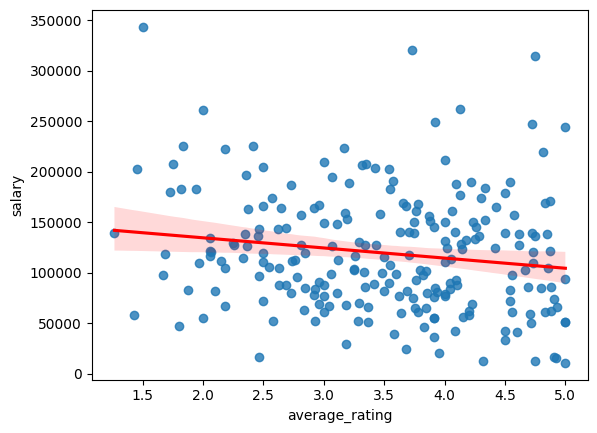

In [18]:
sns.regplot(
    data=tmp[tmp["num_reviews"] > 10],
    x="average_rating",
    y="salary",
    line_kws={"color": "red"},
    fit_reg=True
)